Configuration Initiale et Préparation des Données

In [2]:
# Importations et configuration
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score
from PIL import Image
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast


In [3]:
# Configuration
SEED = 42
IMG_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 3
INIT_LR = 0.0001
USE_AMP = True
NUM_WORKERS = 4 if torch.cuda.is_available() else 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Chargement des données
train_df = pd.read_csv('train.csv')
print(len(train_df))
train_df.head()

3662


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


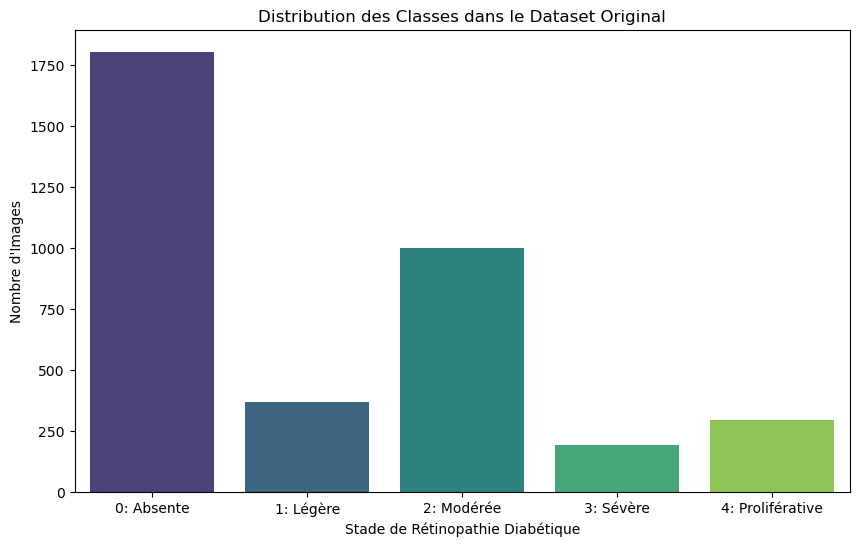

In [7]:
# Visualisation de la distribution des classes
plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosis', data=train_df, palette='viridis')
plt.title('Distribution des Classes dans le Dataset Original')
plt.xlabel('Stade de Rétinopathie Diabétique')
plt.ylabel('Nombre d\'Images')
plt.xticks([0, 1, 2, 3, 4], ['0: Absente', '1: Légère', '2: Modérée', '3: Sévère', '4: Proliférative'])
plt.show()


In [8]:
# Analyse des déséquilibres
class_dist = train_df['diagnosis'].value_counts(normalize=True) * 100
print("Pourcentage par classe:")
print(class_dist)

Pourcentage par classe:
diagnosis
0    49.290005
2    27.280175
1    10.103768
4     8.055707
3     5.270344
Name: proportion, dtype: float64


<h2>Préparation des Données et Augmentation</h2>

In [9]:
# Split stratifié
train_df, valid_df = train_test_split(
    train_df, test_size=0.15, 
    stratify=train_df['diagnosis'], 
    random_state=SEED
)



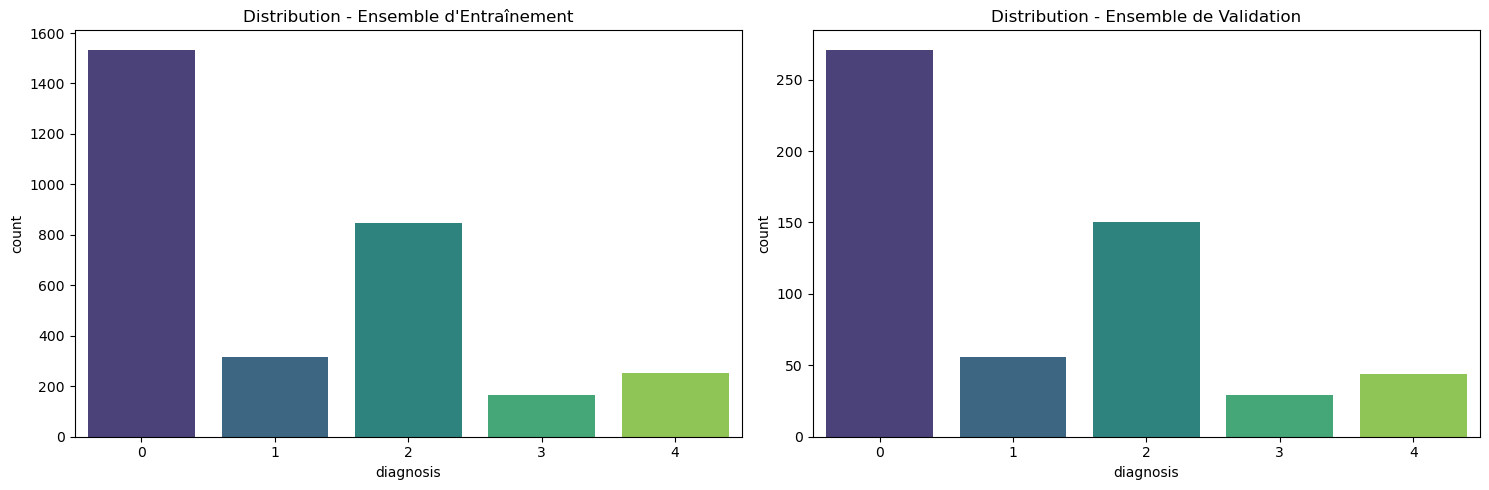

In [10]:
# Visualisation après split
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='diagnosis', data=train_df, palette='viridis', ax=ax[0])
ax[0].set_title('Distribution - Ensemble d\'Entraînement')
sns.countplot(x='diagnosis', data=valid_df, palette='viridis', ax=ax[1])
ax[1].set_title('Distribution - Ensemble de Validation')
plt.tight_layout()
plt.show()

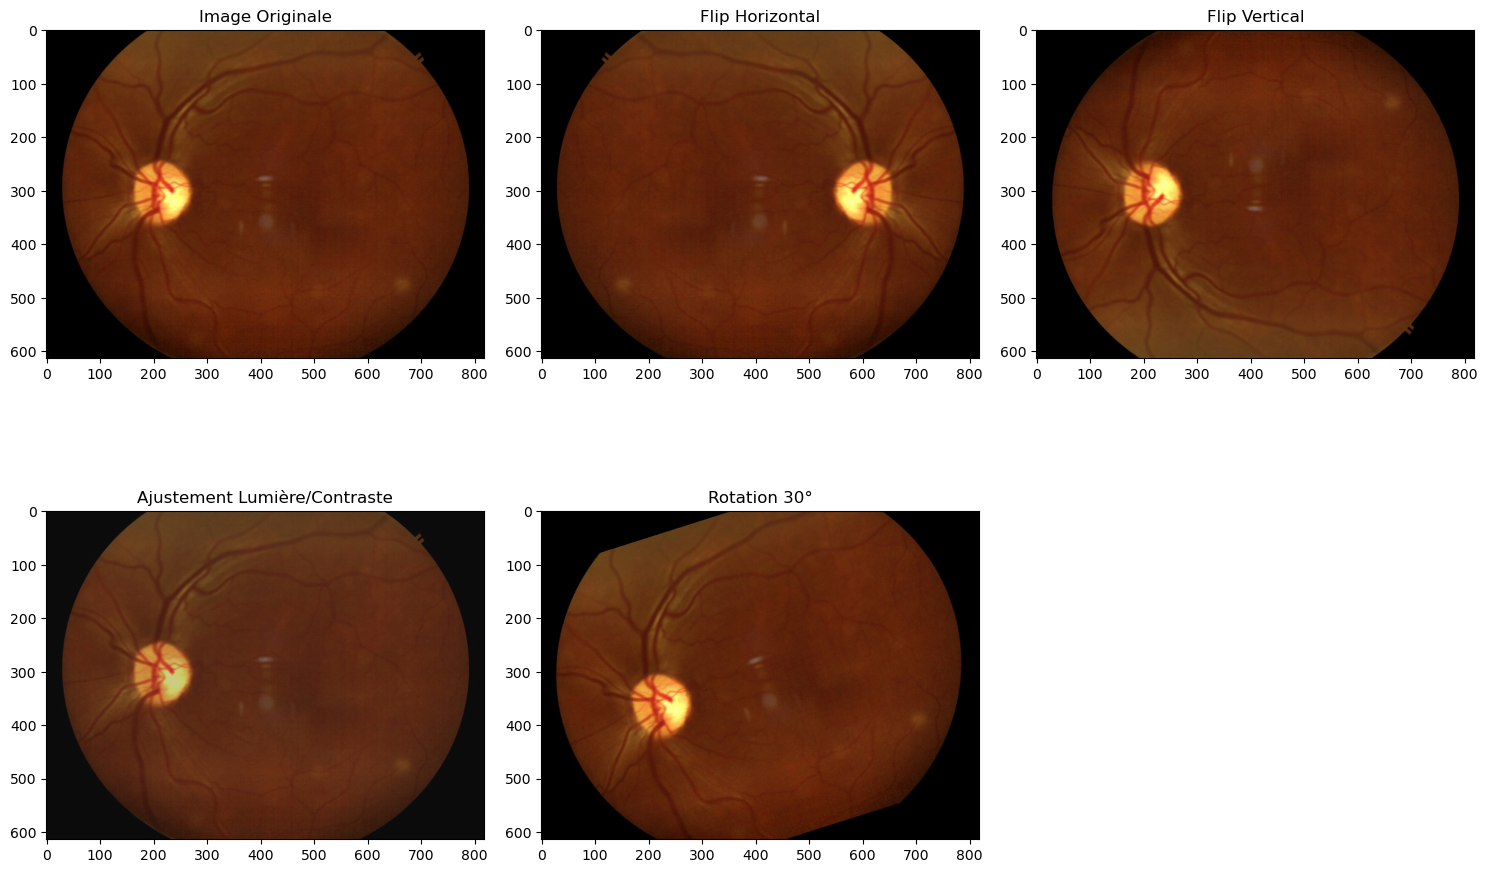

In [11]:
# Transformation des images
def visualize_augmentations():
    sample = train_df.sample(1)
    img_path = os.path.join("train_images", f"{sample['id_code'].values[0]}.png")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(img)
    plt.title('Image Originale')
    
    # Exemples d'augmentations
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()
    ])
    plt.subplot(2, 3, 2)
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.title('Flip Horizontal')
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor()
    ])
    plt.subplot(2, 3, 3)
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.title('Flip Vertical')
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.ToTensor()
    ])
    plt.subplot(2, 3, 4)
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.title('Ajustement Lumière/Contraste')
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(30),
        transforms.ToTensor()
    ])
    plt.subplot(2, 3, 5)
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.title('Rotation 30°')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

<h2>Définition des Modèles</h2>

In [12]:
# CNN Personnalisé
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * (IMG_SIZE//16) * (IMG_SIZE//16), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
# Visualisation de l'architecture
def plot_model_architecture(model, model_name):
    from torchviz import make_dot
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    output = model(dummy_input)
    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.render(f'model_architecture_{model_name}', format='png')
    print(f"Architecture {model_name} sauvegardée comme image.")

In [14]:
# Initialisation des modèles
models_dict = {
    'CustomCNN': CustomCNN(),
    'EfficientNetB0': models.efficientnet_b0(pretrained=True),
    'ResNet50': models.resnet50(pretrained=True)
}


In [15]:
# Modification des modèles pré-entraînés
models_dict['EfficientNetB0'].classifier[1] = nn.Linear(
    models_dict['EfficientNetB0'].classifier[1].in_features, 5)
models_dict['ResNet50'].fc = nn.Linear(
    models_dict['ResNet50'].fc.in_features, 5)

In [16]:
# Visualisation des architectures
for name, model in models_dict.items():
    model = model.to(DEVICE)
    print(f"\n{name} Architecture:")
    print(model)
    plot_model_architecture(model, name)


CustomCNN Architecture:
CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

Entraînement et Évaluation

In [17]:
# Classe Dataset
class EyeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.df.iloc[idx]['id_code']}.png")
        label = self.df.iloc[idx]['diagnosis']
        
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise FileNotFoundError
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = Image.fromarray(img)
            
            if self.transform:
                img = self.transform(img)
                
            return img, label
            
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            blank = torch.zeros(3, IMG_SIZE, IMG_SIZE) if self.transform else np.zeros((IMG_SIZE, IMG_SIZE, 3))
            return blank, label

In [18]:
# Préparation des DataLoaders
def prepare_dataloaders():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_ds = EyeDataset(train_df, "train_images", train_transform, True)
    valid_ds = EyeDataset(valid_df, "train_images", valid_transform)
    
    # Weighted sampler pour gérer le déséquilibre
    class_counts = Counter(train_df['diagnosis'])
    weights = {cls: 1.0/count for cls, count in class_counts.items()}
    sample_weights = [weights[cls] for cls in train_df['diagnosis']]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    valid_loader = DataLoader(
        valid_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    
    return train_loader, valid_loader, class_counts

In [19]:
# Classe Trainer
class Trainer:
    def __init__(self, model, train_loader, valid_loader, class_counts, model_name):
        self.model = model.to(DEVICE)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.model_name = model_name
        
        # Loss avec poids de classe
        weights = 1.0 / torch.tensor(list(class_counts.values()), dtype=torch.float)
        weights = weights / weights.sum()
        self.criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
        
        self.optimizer = AdamW(model.parameters(), lr=INIT_LR, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=2)
        self.scaler = GradScaler(enabled=USE_AMP)
        
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'train_kappa': [], 'val_kappa': [],
            'lr': []
        }
    
    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        all_preds, all_labels = [], []
        
        for images, labels in tqdm(self.train_loader, desc=f"Training {self.model_name}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            self.optimizer.zero_grad()
            
            with autocast(enabled=USE_AMP):
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = correct / len(self.train_loader.dataset)
        epoch_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        return epoch_loss, epoch_acc, epoch_kappa
    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for images, labels in tqdm(self.valid_loader, desc=f"Validating {self.model_name}"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(self.valid_loader.dataset)
        epoch_acc = correct / len(self.valid_loader.dataset)
        epoch_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        return epoch_loss, epoch_acc, epoch_kappa, all_labels, all_preds
    
    def train(self, epochs=EPOCHS):
        best_kappa = -1.0
        
        for epoch in range(epochs):
            train_loss, train_acc, train_kappa = self.train_epoch()
            val_loss, val_acc, val_kappa, val_labels, val_preds = self.validate()
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['train_kappa'].append(train_kappa)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_kappa'].append(val_kappa)
            self.history['lr'].append(self.optimizer.param_groups[0]['lr'])
            
            # Update scheduler
            self.scheduler.step(val_loss)
            
            # Print results
            print(f"\nEpoch {epoch+1}/{epochs} - {self.model_name}:")
            print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Kappa: {train_kappa:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Kappa: {val_kappa:.4f}")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}")
            
            # Save best model
            if val_kappa > best_kappa:
                best_kappa = val_kappa
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'val_kappa': val_kappa,
                    'val_acc': val_acc,
                }, f'best_{self.model_name}.pth')
                print("Model improved - saved")
        
        return self.history, val_labels, val_preds
    
    def plot_training_history(self):
        plt.figure(figsize=(18, 12))
        
        # Loss
        plt.subplot(2, 3, 1)
        plt.plot(self.history['train_loss'], label='Train')
        plt.plot(self.history['val_loss'], label='Validation')
        plt.title(f'Loss - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Accuracy
        plt.subplot(2, 3, 2)
        plt.plot(self.history['train_acc'], label='Train')
        plt.plot(self.history['val_acc'], label='Validation')
        plt.title(f'Accuracy - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Kappa
        plt.subplot(2, 3, 3)
        plt.plot(self.history['train_kappa'], label='Train')
        plt.plot(self.history['val_kappa'], label='Validation')
        plt.title(f'Kappa Score - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Kappa')
        plt.legend()
        
        # Learning Rate
        plt.subplot(2, 3, 4)
        plt.plot(self.history['lr'], label='Learning Rate')
        plt.title(f'Learning Rate - {self.model_name}')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()
        
        # Confusion Matrix
        _, _, _, val_labels, val_preds = self.validate()
        cm = confusion_matrix(val_labels, val_preds)
        plt.subplot(2, 3, 5)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['0', '1', '2', '3', '4'],
                   yticklabels=['0', '1', '2', '3', '4'])
        plt.title(f'Confusion Matrix - {self.model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        plt.tight_layout()
        plt.savefig(f'training_history_{self.model_name}.png')
        plt.show()

# Préparation des données
train_loader, valid_loader, class_counts = prepare_dataloaders()

Entraînement des Modèles et Comparaison


Entraînement du modèle: CustomCNN


Validating CustomCNN: 100%|██████████| 35/35 [02:20<00:00,  4.02s/it]



Epoch 1/3 - CustomCNN:
Train Loss: 2.3449 | Acc: 0.3554 | Kappa: 0.3543
Val Loss: 1.3356 | Acc: 0.4527 | Kappa: 0.4632
LR: 0.000100
Model improved - saved


Validating CustomCNN: 100%|██████████| 35/35 [02:19<00:00,  3.99s/it]



Epoch 2/3 - CustomCNN:
Train Loss: 1.2424 | Acc: 0.3978 | Kappa: 0.4325
Val Loss: 1.3087 | Acc: 0.4455 | Kappa: 0.5549
LR: 0.000100
Model improved - saved


Validating CustomCNN: 100%|██████████| 35/35 [02:14<00:00,  3.85s/it]



Epoch 3/3 - CustomCNN:
Train Loss: 1.2311 | Acc: 0.3988 | Kappa: 0.4499
Val Loss: 1.2625 | Acc: 0.4745 | Kappa: 0.5873
LR: 0.000100
Model improved - saved


Validating CustomCNN: 100%|██████████| 35/35 [02:12<00:00,  3.80s/it]


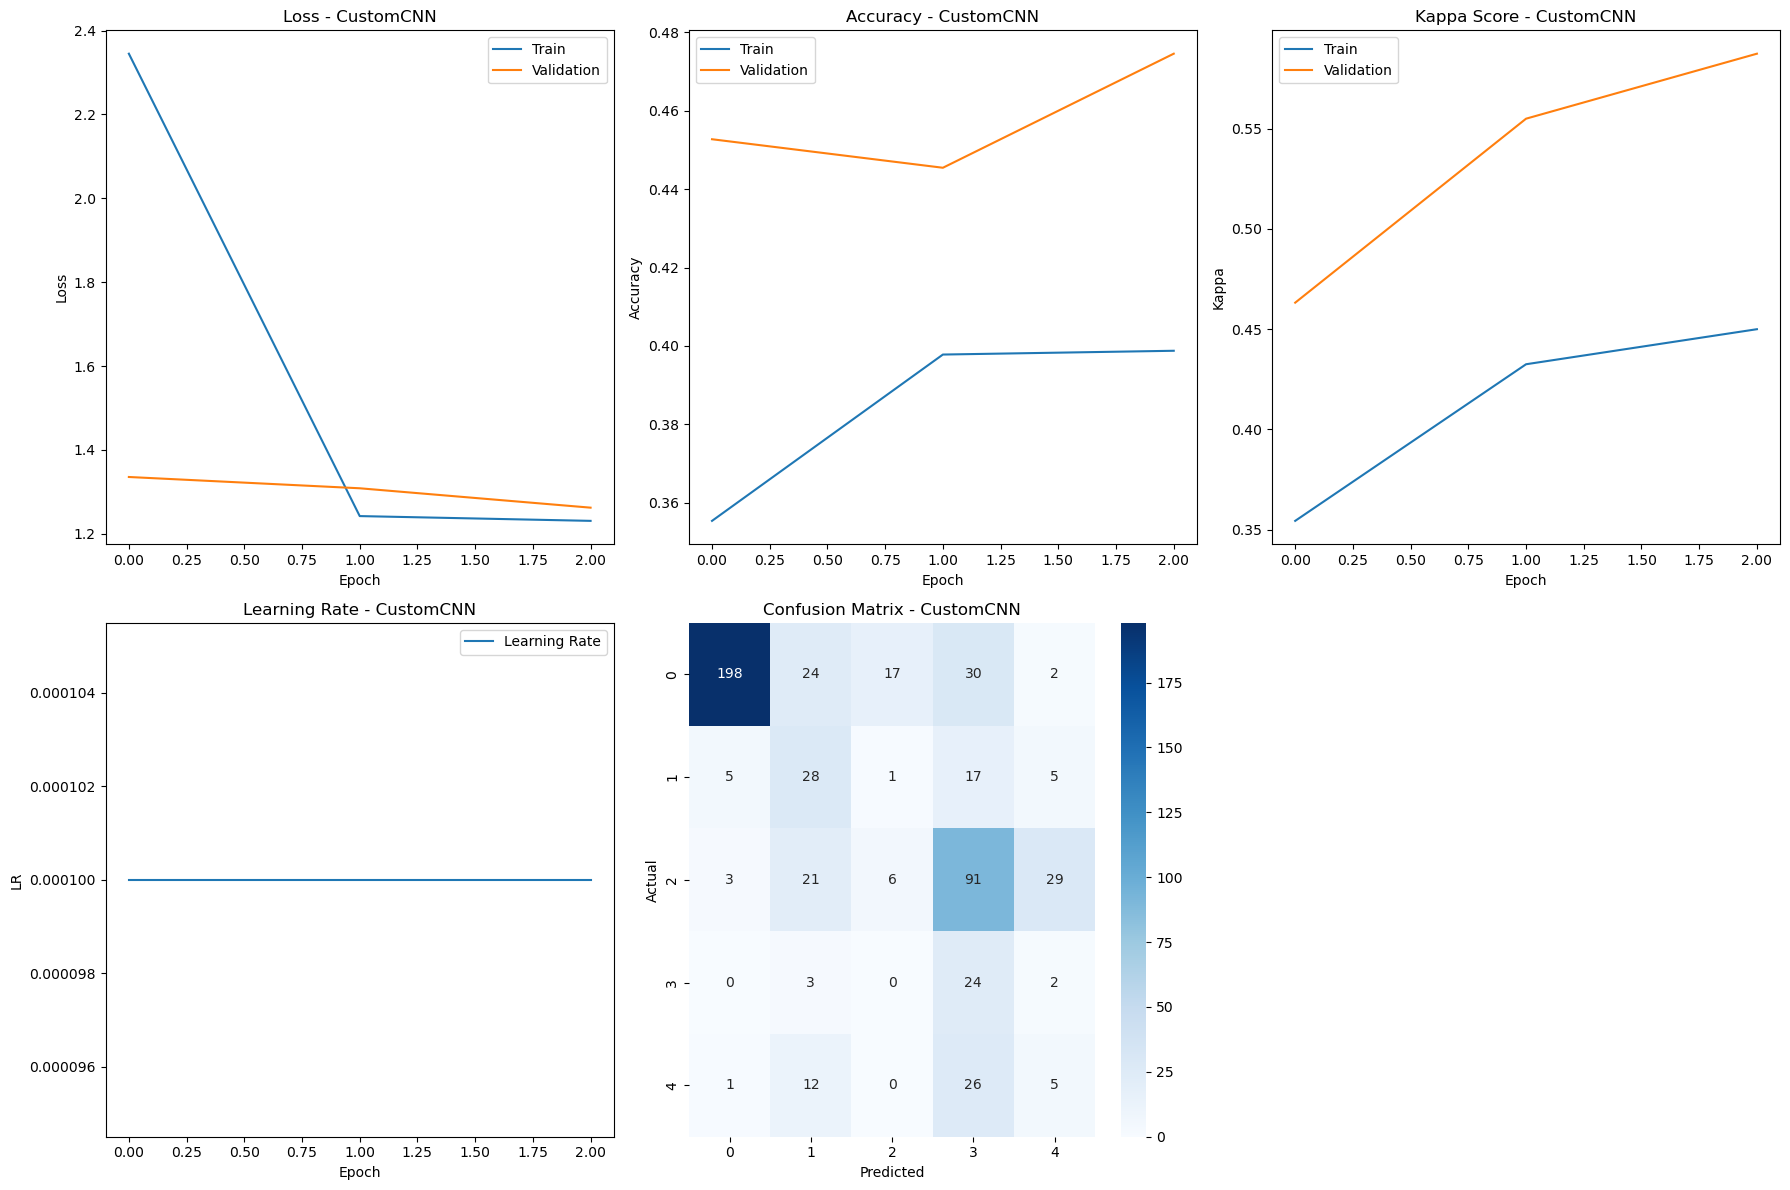


Classification Report - CustomCNN:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       271
           1       0.32      0.50      0.39        56
           2       0.25      0.04      0.07       150
           3       0.13      0.83      0.22        29
           4       0.12      0.11      0.11        44

    accuracy                           0.47       550
   macro avg       0.35      0.44      0.32       550
weighted avg       0.59      0.47      0.49       550


Entraînement du modèle: EfficientNetB0


Validating EfficientNetB0: 100%|██████████| 35/35 [03:00<00:00,  5.16s/it]



Epoch 1/3 - EfficientNetB0:
Train Loss: 0.9964 | Acc: 0.5209 | Kappa: 0.6816
Val Loss: 0.9367 | Acc: 0.6200 | Kappa: 0.7938
LR: 0.000100
Model improved - saved


Validating EfficientNetB0: 100%|██████████| 35/35 [03:00<00:00,  5.17s/it]



Epoch 2/3 - EfficientNetB0:
Train Loss: 0.6783 | Acc: 0.6382 | Kappa: 0.7949
Val Loss: 0.8197 | Acc: 0.6255 | Kappa: 0.7975
LR: 0.000100
Model improved - saved


Validating EfficientNetB0: 100%|██████████| 35/35 [03:01<00:00,  5.20s/it]



Epoch 3/3 - EfficientNetB0:
Train Loss: 0.5817 | Acc: 0.6597 | Kappa: 0.8183
Val Loss: 0.7293 | Acc: 0.6564 | Kappa: 0.8255
LR: 0.000100
Model improved - saved


Validating EfficientNetB0: 100%|██████████| 35/35 [02:57<00:00,  5.08s/it]


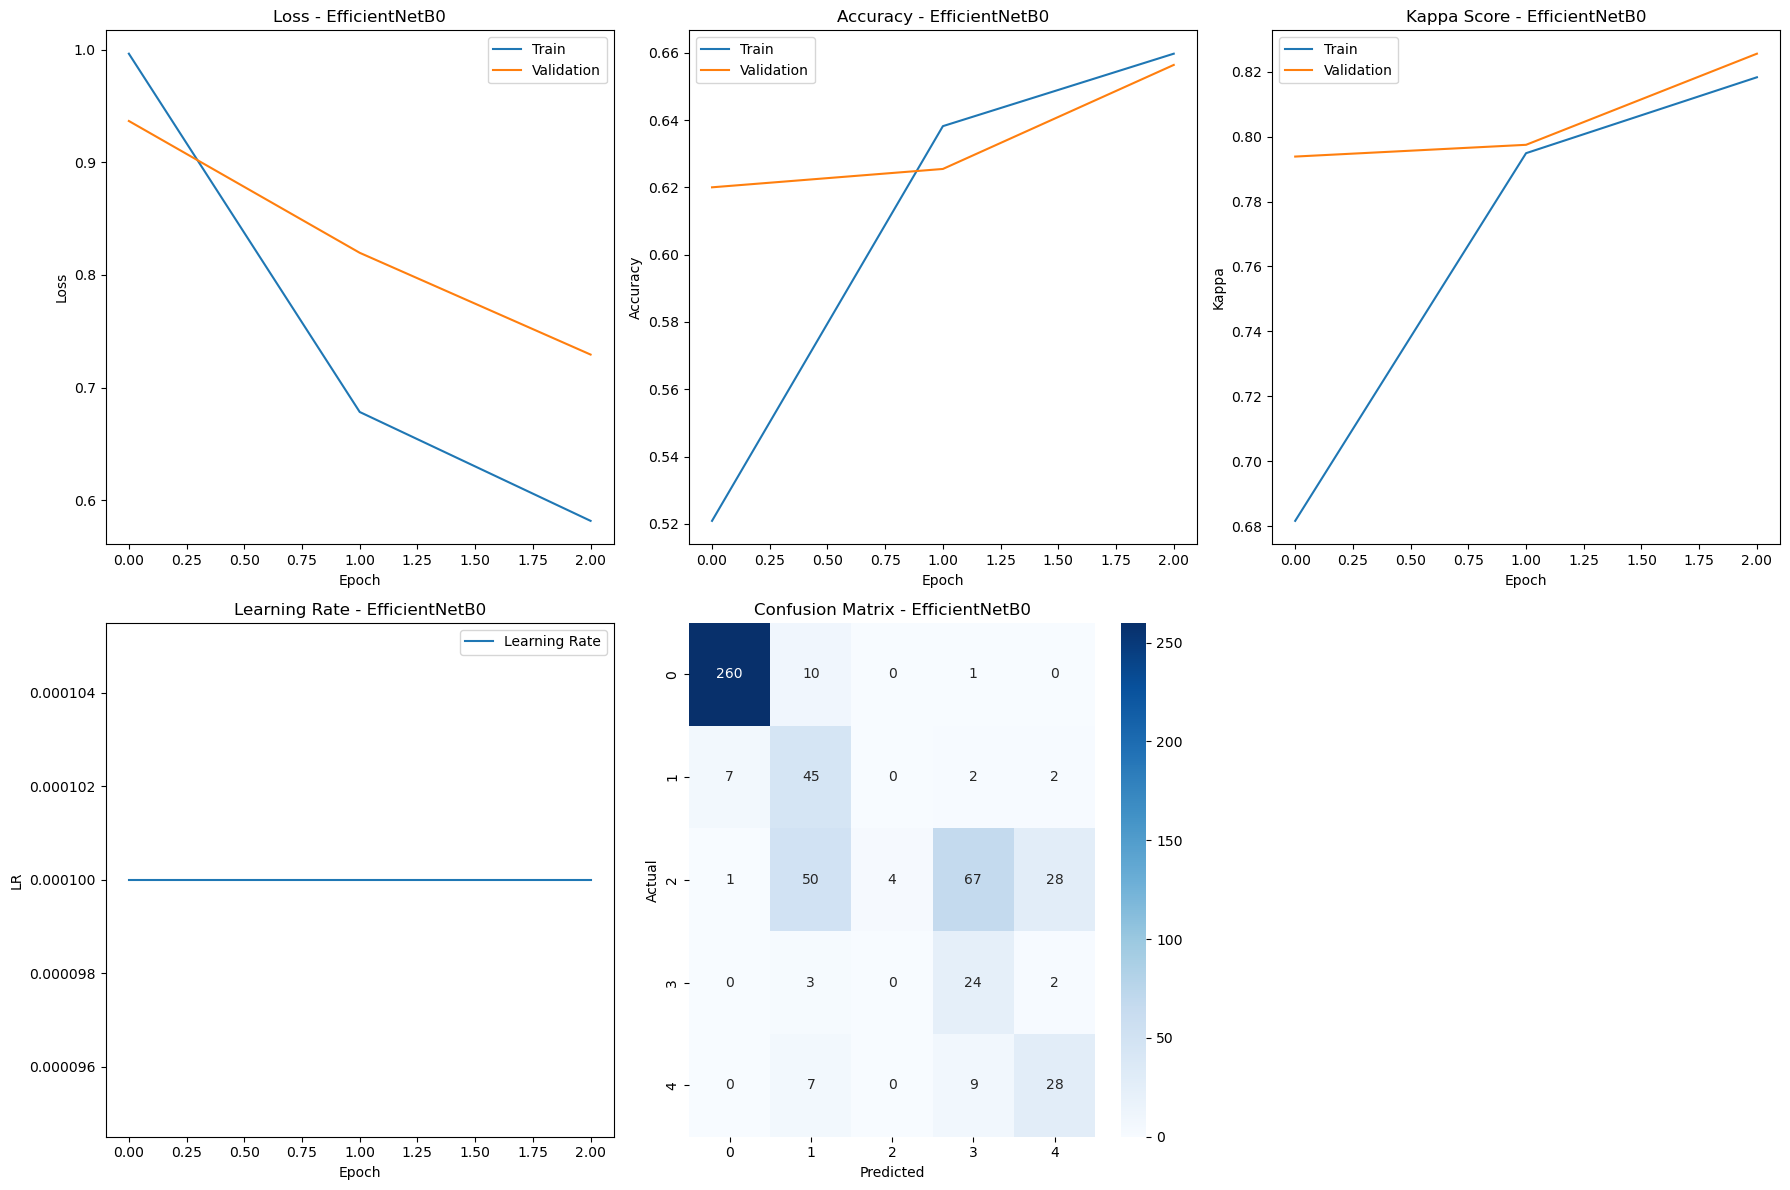


Classification Report - EfficientNetB0:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       271
           1       0.39      0.80      0.53        56
           2       1.00      0.03      0.05       150
           3       0.23      0.83      0.36        29
           4       0.47      0.64      0.54        44

    accuracy                           0.66       550
   macro avg       0.61      0.65      0.49       550
weighted avg       0.84      0.66      0.61       550


Entraînement du modèle: ResNet50


Validating ResNet50: 100%|██████████| 35/35 [06:11<00:00, 10.61s/it]



Epoch 1/3 - ResNet50:
Train Loss: 0.8402 | Acc: 0.5656 | Kappa: 0.7379
Val Loss: 1.0379 | Acc: 0.5491 | Kappa: 0.7914
LR: 0.000100
Model improved - saved


Validating ResNet50: 100%|██████████| 35/35 [06:10<00:00, 10.60s/it]



Epoch 2/3 - ResNet50:
Train Loss: 0.6620 | Acc: 0.6452 | Kappa: 0.8138
Val Loss: 0.8551 | Acc: 0.6400 | Kappa: 0.8025
LR: 0.000100
Model improved - saved


Validating ResNet50: 100%|██████████| 35/35 [06:07<00:00, 10.50s/it]



Epoch 3/3 - ResNet50:
Train Loss: 0.6063 | Acc: 0.6607 | Kappa: 0.8135
Val Loss: 0.7259 | Acc: 0.6582 | Kappa: 0.8258
LR: 0.000100
Model improved - saved


Validating ResNet50: 100%|██████████| 35/35 [06:02<00:00, 10.34s/it]


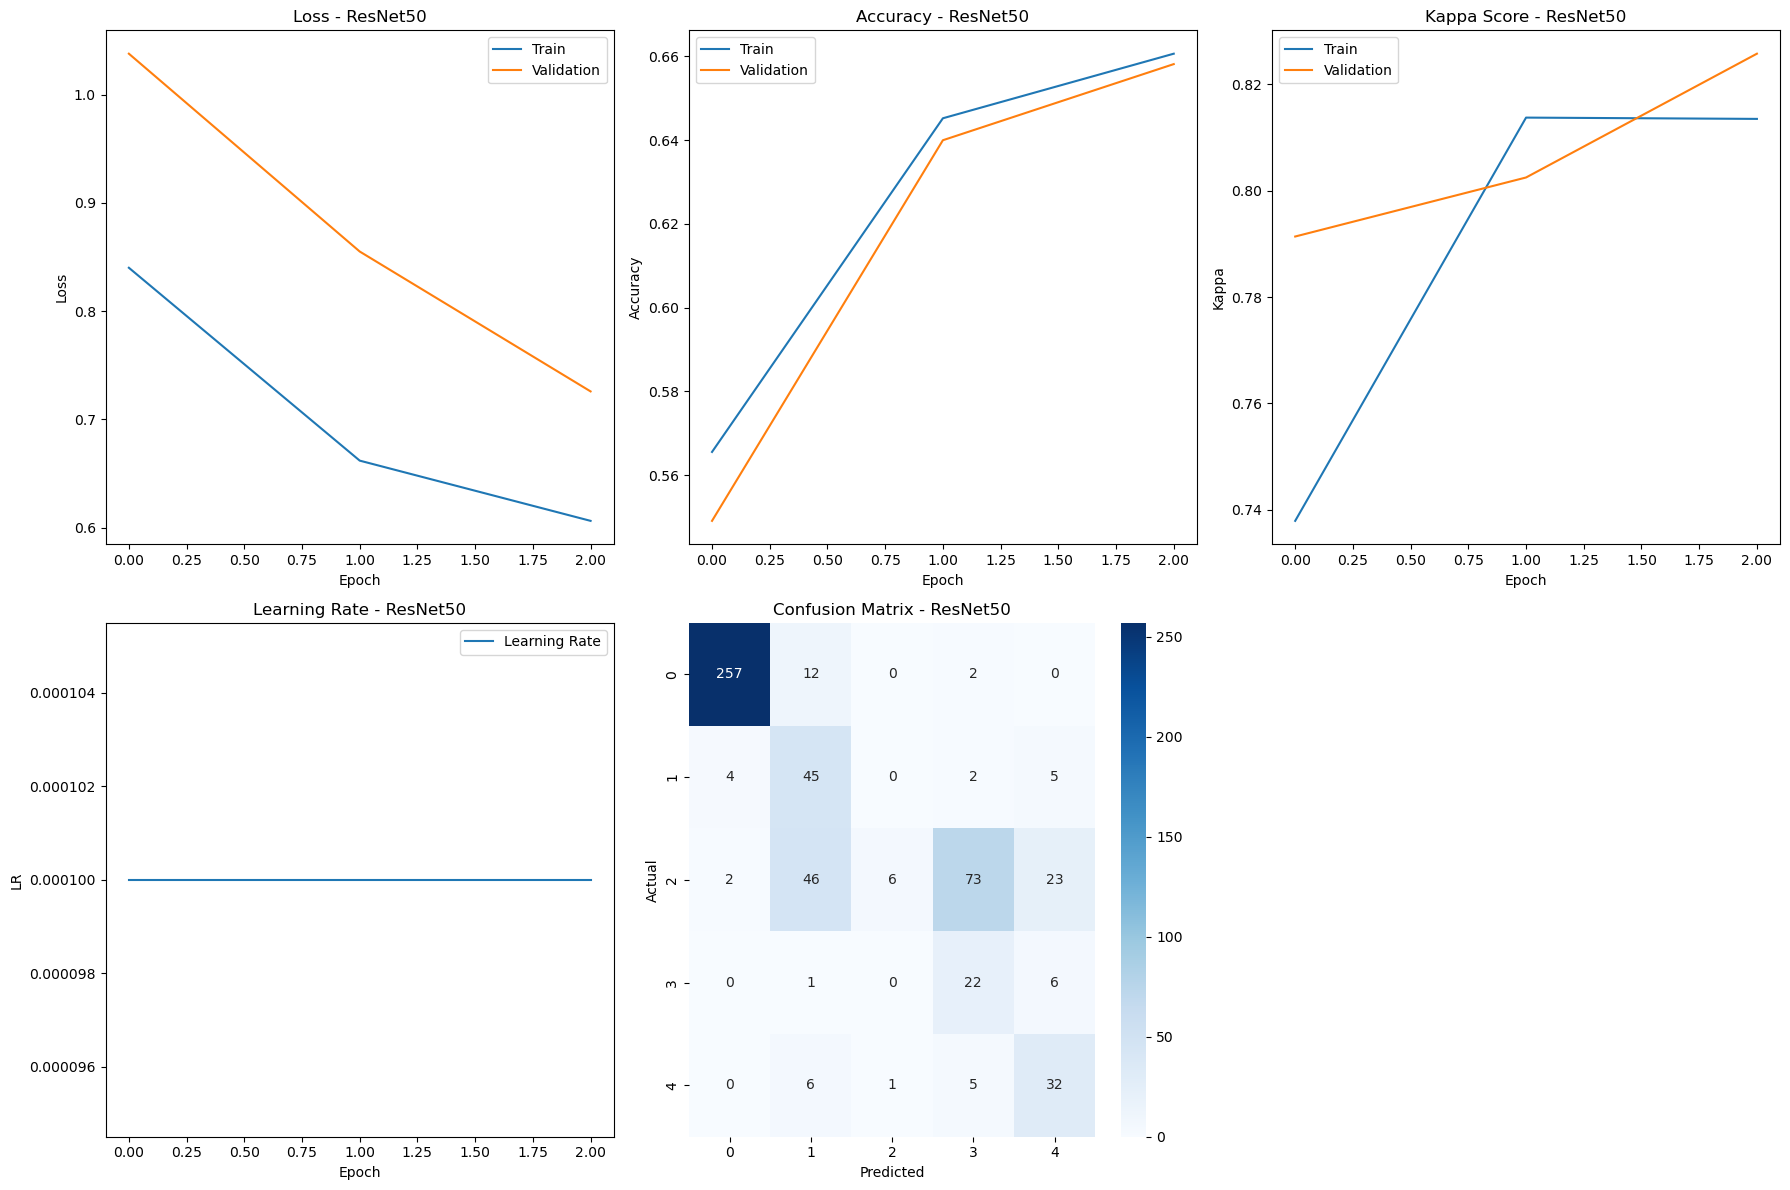


Classification Report - ResNet50:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       271
           1       0.41      0.80      0.54        56
           2       0.86      0.04      0.08       150
           3       0.21      0.76      0.33        29
           4       0.48      0.73      0.58        44

    accuracy                           0.66       550
   macro avg       0.59      0.66      0.50       550
weighted avg       0.81      0.66      0.61       550



In [20]:
# Entraînement et évaluation des modèles
results = []

for model_name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"Entraînement du modèle: {model_name}")
    print(f"{'='*50}")
    
    trainer = Trainer(model, train_loader, valid_loader, class_counts, model_name)
    history, val_labels, val_preds = trainer.train()
    trainer.plot_training_history()
    
    # Classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(val_labels, val_preds, target_names=['0', '1', '2', '3', '4']))
    
    # Save results
    results.append({
        'model': model_name,
        'val_acc': history['val_acc'][-1],
        'val_kappa': history['val_kappa'][-1],
        'best_val_acc': max(history['val_acc']),
        'best_val_kappa': max(history['val_kappa']),
        'report': classification_report(val_labels, val_preds, output_dict=True)
    })

In [21]:
# Comparaison des modèles
comparison_df = pd.DataFrame(results)

In [22]:
print(comparison_df.columns)  # Vérifiez les noms exacts des colonnes
print(comparison_df.head())   # Affichez les premières lignes

Index(['model', 'val_acc', 'val_kappa', 'best_val_acc', 'best_val_kappa',
       'report'],
      dtype='object')
            model   val_acc  val_kappa  best_val_acc  best_val_kappa  \
0       CustomCNN  0.474545   0.587347      0.474545        0.587347   
1  EfficientNetB0  0.656364   0.825526      0.656364        0.825526   
2        ResNet50  0.658182   0.825776      0.658182        0.825776   

                                              report  
0  {'0': {'precision': 0.9565217391304348, 'recal...  
1  {'0': {'precision': 0.9701492537313433, 'recal...  
2  {'0': {'precision': 0.9771863117870723, 'recal...  


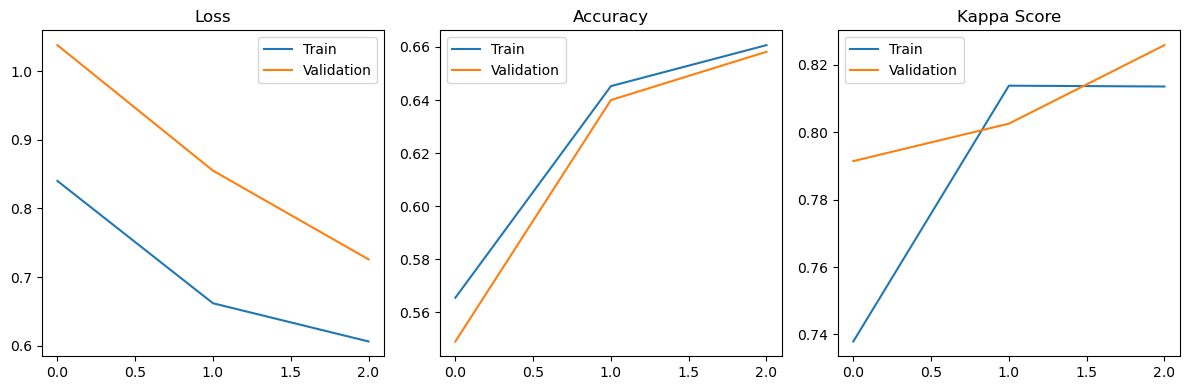

In [23]:
# Courbes d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['train_kappa'], label='Train')
plt.plot(history['val_kappa'], label='Validation')
plt.title('Kappa Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

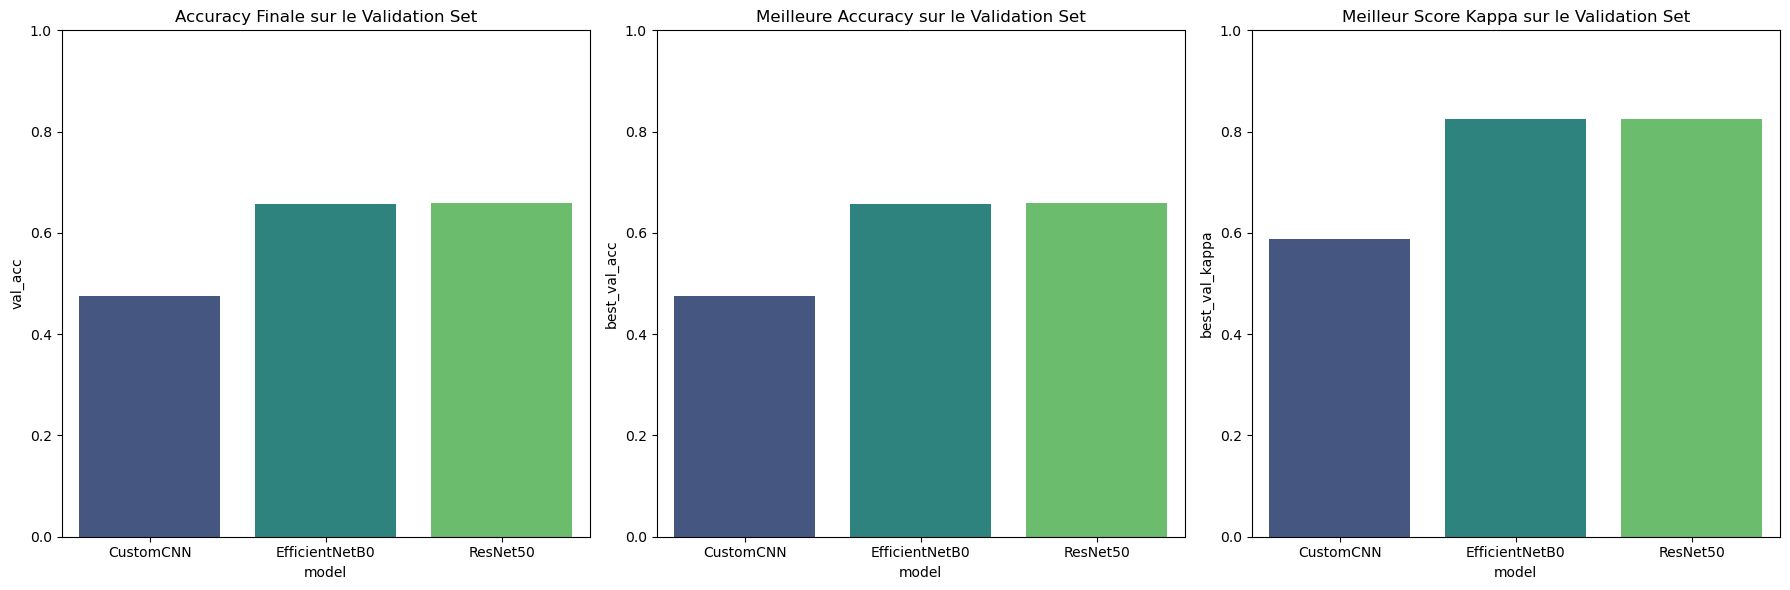

In [28]:
# Visualisation comparative
plt.figure(figsize=(18, 6))

# Accuracy comparison
plt.subplot(1, 3, 1)
sns.barplot(
    x=comparison_df['model'], 
    y=comparison_df['val_acc'], 
    palette='viridis'
)
plt.title('Accuracy Finale sur le Validation Set')
plt.ylim(0, 1)

# Best accuracy comparison
plt.subplot(1, 3, 2)
sns.barplot(x='model', y='best_val_acc', data=comparison_df, palette='viridis')
plt.title('Meilleure Accuracy sur le Validation Set')
plt.ylim(0, 1)

# Kappa comparison
plt.subplot(1, 3, 3)
sns.barplot(x='model', y='best_val_kappa', data=comparison_df, palette='viridis')
plt.title('Meilleur Score Kappa sur le Validation Set')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()



In [30]:
# Affichage des résultats
print("\nComparaison des Modèles:")
print(comparison_df[['model', 'val_acc', 'val_kappa', 'best_val_acc', 'best_val_kappa']])

# Sauvegarde des résultats
comparison_df.to_csv('model_comparison_results.csv', index=False)


Comparaison des Modèles:
            model   val_acc  val_kappa  best_val_acc  best_val_kappa
0       CustomCNN  0.474545   0.587347      0.474545        0.587347
1  EfficientNetB0  0.656364   0.825526      0.656364        0.825526
2        ResNet50  0.658182   0.825776      0.658182        0.825776


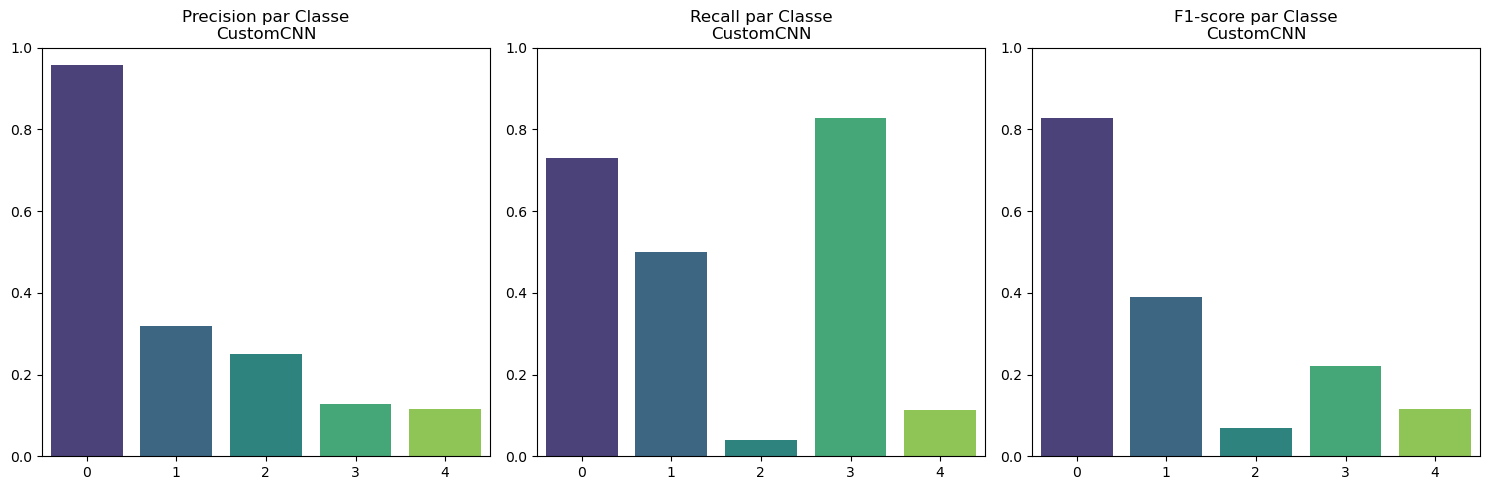

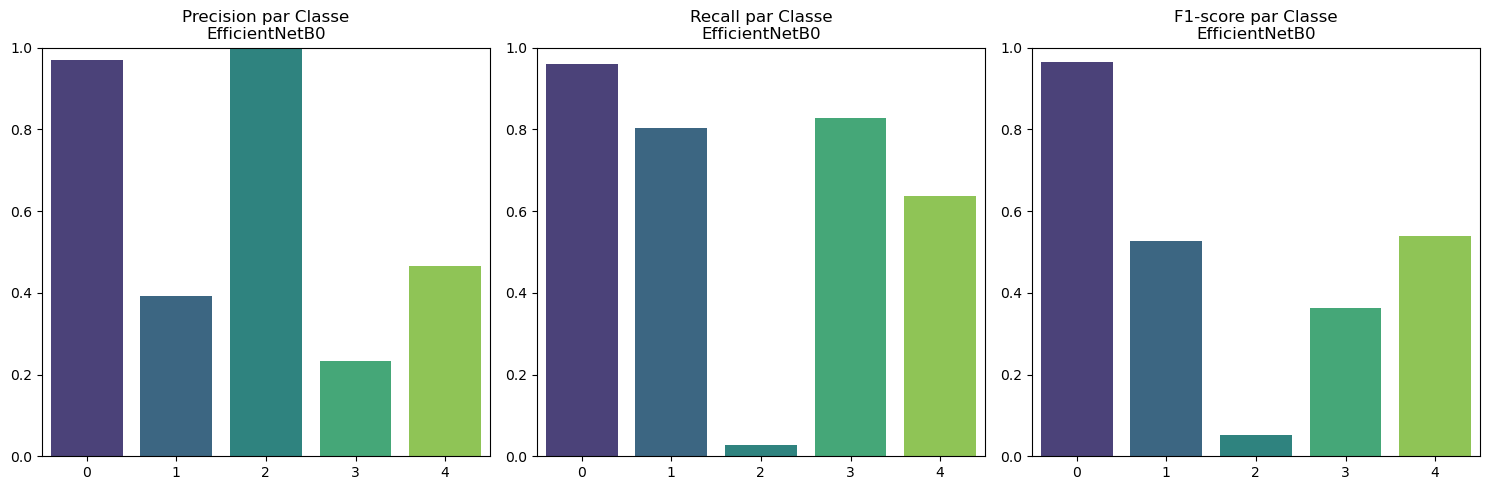

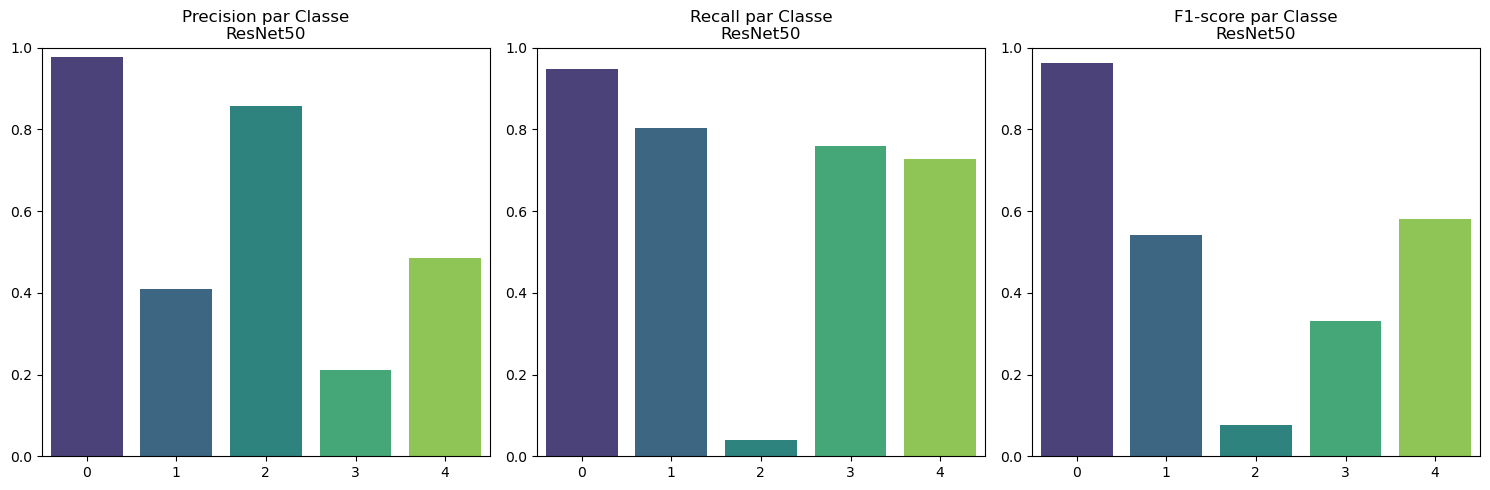

In [31]:
# Analyse détaillée par classe
def plot_class_analysis(results):
    for result in results:
        model_name = result['model']
        report = result['report']
        
        # Préparation des données
        metrics = ['precision', 'recall', 'f1-score']
        classes = ['0', '1', '2', '3', '4']
        data = {m: [report[c][m] for c in classes] for m in metrics}
        
        # Visualisation
        plt.figure(figsize=(15, 5))
        for i, metric in enumerate(metrics, 1):
            plt.subplot(1, 3, i)
            sns.barplot(x=classes, y=data[metric], palette='viridis')
            plt.title(f'{metric.capitalize()} par Classe\n{model_name}')
            plt.ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig(f'class_metrics_{model_name}.png')
        plt.show()

plot_class_analysis(results)

In [35]:
print(results[0].keys())  

dict_keys(['model', 'val_acc', 'val_kappa', 'best_val_acc', 'best_val_kappa', 'report'])
